# TP Final - Análisis de Series Temporales - Especialización en Inteligencia Artificial


### Ajustar y predecir usando **redes neuronales LSTM**. Comparar con **predicciones** usando SARIMA y extraer conclusiones.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
from scipy.stats import boxcox 
from statsmodels.tsa.statespace import sarimax
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

<AxesSubplot:xlabel='survey_date'>

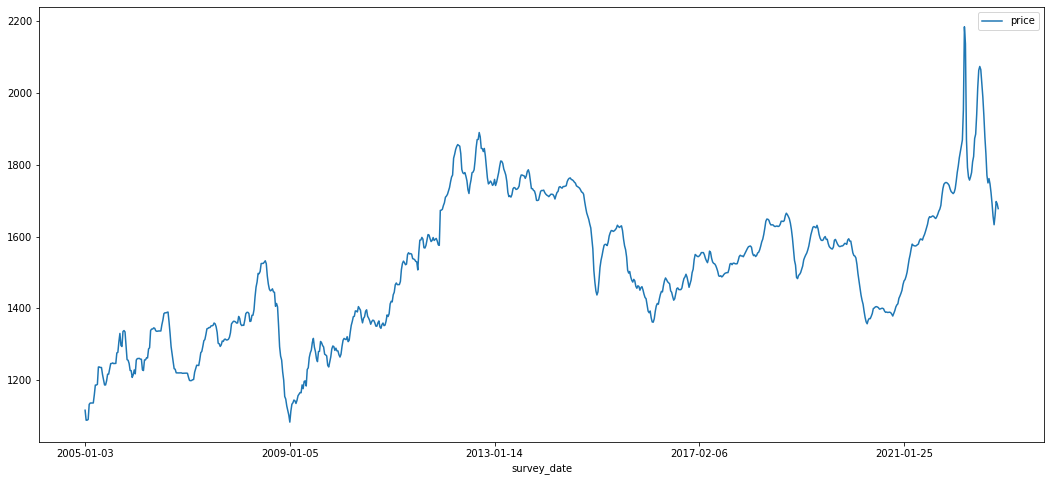

In [170]:
df = pd.read_csv("datasets/weekly_fuel_prices_all_data_from_2005_to_20221102.csv", index_col=0)
df = df.sort_values(by="survey_date")
matplotlib.rcParams['figure.figsize'] = [18,8]
df=df.groupby('product_name')['price'].get_group('Euro-Super 95')
df.plot(legend=True)

In [171]:
class Optimization:

    def __init__(self, model, loss_fn, optimizer):

        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):

        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
 
        device = ""
        
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

       
            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                   
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        device = ""
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"

        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = torch.nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [172]:
df_features = df.copy()
df_features = df_features.reset_index()

df_features = (
                df_features
                .assign(day = pd.to_datetime(df_features['survey_date']).dt.day)
                .assign(month = pd.to_datetime(df_features['survey_date']).dt.month)
                .assign(year = pd.to_datetime(df_features['survey_date']).dt.year)
              )
df_features['order'] = np.arange(len(df_features)) 
df_features.drop(['survey_date'], axis=1, inplace=True)
df_features

,price,day,month,year,order
0,1115.75,3,1,2005,0
1,1088.00,10,1,2005,1
2,1088.14,17,1,2005,2
3,1090.01,24,1,2005,3
4,1132.11,31,1,2005,4
...,...,...,...,...,...
888,1632.81,3,10,2022,888
889,1659.78,10,10,2022,889
890,1697.59,17,10,2022,890
891,1691.24,24,10,2022,891


In [173]:
y = df_features[['price']]
X = df_features.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [174]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

y_train_sc = scaler.fit_transform(y_train)
y_val_sc = scaler.transform(y_val)
y_test_sc = scaler.transform(y_test)

y_sc = scaler.transform(y)
X_sc = scaler.fit_transform(X)

In [199]:
# Dataloaders
batch_size = 64

train_features = torch.Tensor(X_train_sc)
train_targets = torch.Tensor(y_train_sc)
val_features = torch.Tensor(X_val_sc)
val_targets = torch.Tensor(y_val_sc)
test_features = torch.Tensor(X_test_sc)
test_targets = torch.Tensor(y_test_sc)

X_features = torch.Tensor(X_sc)
y_targets = torch.Tensor(y_sc)


train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

complete_dataset = TensorDataset(X_features, y_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

complete_dataset_loader = DataLoader(complete_dataset, batch_size=1, shuffle=False, drop_last=True)

[1/500] Training loss: 0.3114	 Validation loss: 0.3625
[2/500] Training loss: 0.2537	 Validation loss: 0.2875
[3/500] Training loss: 0.1902	 Validation loss: 0.1922
[4/500] Training loss: 0.1136	 Validation loss: 0.0767
[5/500] Training loss: 0.0615	 Validation loss: 0.0125
[6/500] Training loss: 0.0735	 Validation loss: 0.0112
[7/500] Training loss: 0.0700	 Validation loss: 0.0167
[8/500] Training loss: 0.0755	 Validation loss: 0.0226
[9/500] Training loss: 0.0716	 Validation loss: 0.0220
[10/500] Training loss: 0.0668	 Validation loss: 0.0192
[11/500] Training loss: 0.0672	 Validation loss: 0.0170
[12/500] Training loss: 0.0671	 Validation loss: 0.0152
[13/500] Training loss: 0.0685	 Validation loss: 0.0154
[14/500] Training loss: 0.0658	 Validation loss: 0.0157
[15/500] Training loss: 0.0654	 Validation loss: 0.0153
[16/500] Training loss: 0.0686	 Validation loss: 0.0148
[17/500] Training loss: 0.0641	 Validation loss: 0.0138
[18/500] Training loss: 0.0617	 Validation loss: 0.0123
[

[147/500] Training loss: 0.0261	 Validation loss: 0.0066
[148/500] Training loss: 0.0259	 Validation loss: 0.0067
[149/500] Training loss: 0.0265	 Validation loss: 0.0069
[150/500] Training loss: 0.0261	 Validation loss: 0.0069
[151/500] Training loss: 0.0256	 Validation loss: 0.0067
[152/500] Training loss: 0.0250	 Validation loss: 0.0070
[153/500] Training loss: 0.0249	 Validation loss: 0.0073
[154/500] Training loss: 0.0253	 Validation loss: 0.0074
[155/500] Training loss: 0.0264	 Validation loss: 0.0071
[156/500] Training loss: 0.0257	 Validation loss: 0.0074
[157/500] Training loss: 0.0228	 Validation loss: 0.0069
[158/500] Training loss: 0.0249	 Validation loss: 0.0069
[159/500] Training loss: 0.0242	 Validation loss: 0.0068
[160/500] Training loss: 0.0244	 Validation loss: 0.0069
[161/500] Training loss: 0.0254	 Validation loss: 0.0074
[162/500] Training loss: 0.0228	 Validation loss: 0.0078
[163/500] Training loss: 0.0255	 Validation loss: 0.0088
[164/500] Training loss: 0.0254

[291/500] Training loss: 0.0181	 Validation loss: 0.0095
[292/500] Training loss: 0.0205	 Validation loss: 0.0081
[293/500] Training loss: 0.0195	 Validation loss: 0.0097
[294/500] Training loss: 0.0185	 Validation loss: 0.0112
[295/500] Training loss: 0.0187	 Validation loss: 0.0093
[296/500] Training loss: 0.0185	 Validation loss: 0.0096
[297/500] Training loss: 0.0187	 Validation loss: 0.0088
[298/500] Training loss: 0.0196	 Validation loss: 0.0087
[299/500] Training loss: 0.0208	 Validation loss: 0.0092
[300/500] Training loss: 0.0193	 Validation loss: 0.0093
[301/500] Training loss: 0.0189	 Validation loss: 0.0086
[302/500] Training loss: 0.0191	 Validation loss: 0.0081
[303/500] Training loss: 0.0187	 Validation loss: 0.0090
[304/500] Training loss: 0.0205	 Validation loss: 0.0098
[305/500] Training loss: 0.0197	 Validation loss: 0.0088
[306/500] Training loss: 0.0191	 Validation loss: 0.0082
[307/500] Training loss: 0.0187	 Validation loss: 0.0084
[308/500] Training loss: 0.0192

[435/500] Training loss: 0.0177	 Validation loss: 0.0098
[436/500] Training loss: 0.0174	 Validation loss: 0.0090
[437/500] Training loss: 0.0177	 Validation loss: 0.0090
[438/500] Training loss: 0.0172	 Validation loss: 0.0095
[439/500] Training loss: 0.0174	 Validation loss: 0.0098
[440/500] Training loss: 0.0168	 Validation loss: 0.0097
[441/500] Training loss: 0.0173	 Validation loss: 0.0093
[442/500] Training loss: 0.0187	 Validation loss: 0.0087
[443/500] Training loss: 0.0162	 Validation loss: 0.0089
[444/500] Training loss: 0.0177	 Validation loss: 0.0093
[445/500] Training loss: 0.0190	 Validation loss: 0.0085
[446/500] Training loss: 0.0177	 Validation loss: 0.0094
[447/500] Training loss: 0.0185	 Validation loss: 0.0091
[448/500] Training loss: 0.0180	 Validation loss: 0.0084
[449/500] Training loss: 0.0176	 Validation loss: 0.0085
[450/500] Training loss: 0.0181	 Validation loss: 0.0101
[451/500] Training loss: 0.0186	 Validation loss: 0.0098
[452/500] Training loss: 0.0165

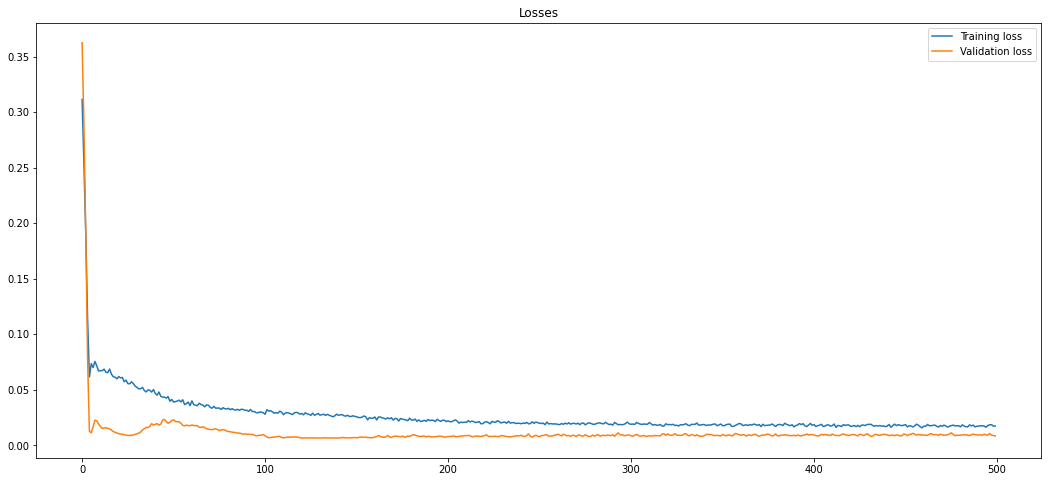

In [176]:
# Parametros del modelo
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 4
batch_size = 64
dropout = 0.8
n_epochs = 500
learning_rate = 1e-3
weight_decay = 1e-4

# Defino Modelo
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

# Defino Loss function
loss_fn = torch.nn.MSELoss(reduction="mean")

# Defino Optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Instancio clase para realizar el entrenamiento y evaluación
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [439]:
model.lstm

LSTM(4, 64, num_layers=4, batch_first=True, dropout=0.8)

In [440]:
print(model.fc)

Linear(in_features=64, out_features=1, bias=True)


In [441]:
predictions, original = opt.evaluate(test_loader, batch_size=1, n_features=input_dim)

In [442]:
# Funciones para re-escalar las predicciones (porque los datos estaban transformados con un scaler)
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

vals = np.concatenate(original, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()

df_result = pd.DataFrame(data={"original": vals, "prediction": preds}, index=X_test.head(len(vals)).index)
df_result = df_result.sort_index()
#df_result = inverse_transform(scaler, df_result, [["original", "prediction"]])

In [443]:
df_result = pd.DataFrame(data={"original": vals, "prediction": preds}, index=X_test.head(len(vals)).index)
df_result = df_result.sort_index()

In [444]:
# Preparo resultados para graficar
df_fecha = df.copy()
df_fecha = df_fecha.reset_index()
df_result['survey_date'] = df_fecha['survey_date'].astype('datetime64')
df_result = df_result.set_index('survey_date')

Text(0.5, 1.0, 'Predicción con el dataset de Test')

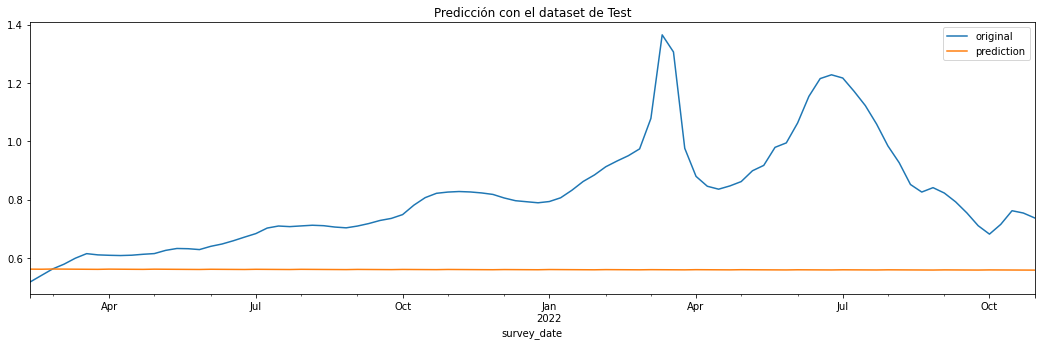

In [445]:
# Plot
df_result.plot(figsize=(18,5))
plt.title("Predicción con el dataset de Test")

Hago inferencias con todo el dataset para ver que diferencias hay entre la gráfica original y la predicción de la NN.

In [446]:
predictions, original = opt.evaluate(complete_dataset_loader, batch_size=1, n_features=input_dim)

In [447]:
df_result = pd.DataFrame(data={"original": original, "predictions": predictions}, index=X.head(len(predictions)).index)
df_result = df_result.sort_index()
df_fecha = df.copy()
df_result['survey_date'] = df_fecha['survey_date']

In [448]:
df_result['original'] = df_result['original'].astype(float)
df_result['predictions'] = df_result['predictions'].astype(float)

Text(0.5, 1.0, 'Predicción con todo el dataset')

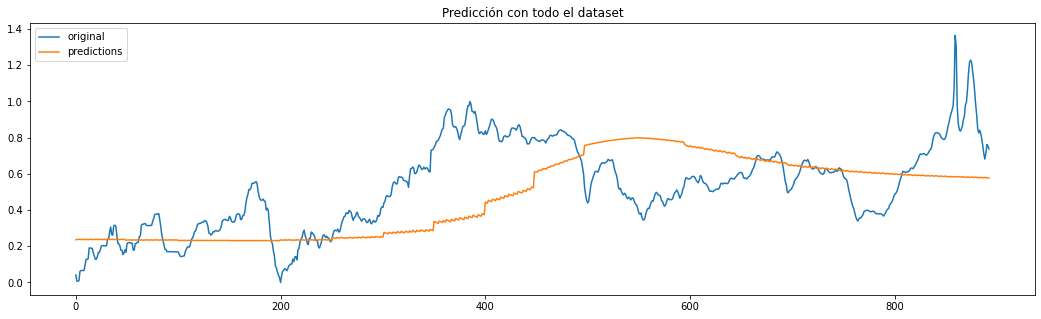

In [449]:
# Plot
df_result.plot(figsize=(18,5))
plt.title("Predicción con todo el dataset")

### En comparación con las predicciones hechas usando (S)ARIMA, la red LSTM no parece ajustar correctamente la serie temporal. Se intentó modificar el batch size, el número de epochs del entrenamiento, el learning rate y el split del dataset en train, test y validation, obteniendose el mejor resultado con los parámetros utilizados en éste Notebook. Se considera que puede deberse a la heteroscedasticidad de la variable (económica) el pésimo fit de la red.